In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pylightcurve as plc
import pandas as pd
import random
import os
from pylightcurve.models.exoplanet_lc import PyLCProcessError
from scipy import stats
import seaborn as sns
import sys

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#### Functions to generate light curves either with or without cloud modulation

In [36]:
# Create output directory for plots
os.makedirs('lightcurve_plots', exist_ok=True)

print("Initializing pylightcurve and loading planetary database...")

# Define type of atmospheric/planetary variability
def add_cloud_modulation(time, flux, amplitude=0.001, timescale=0.2):
    """Add cloud modulation with smooth variations - clouds cause dimming"""
    periods = np.array([0.2, 0.5, 1.0, 2.0]) * timescale * (time[-1] - time[0])
    cloud_signal = np.zeros_like(flux)
    for period in periods:
        phase = 2 * np.pi * time / period
        cloud_signal += np.sin(phase + np.random.rand() * 2 * np.pi)

    # Normalize to [-1, 1] then make negative (clouds dim light)
    cloud_signal = cloud_signal / np.max(np.abs(cloud_signal)) * amplitude
    cloud_signal = -np.abs(cloud_signal)  # Ensure always negative (dimming)

    # Apply cloud modulation as multiplicative dimming
    modified_flux = flux * (1 + cloud_signal)

    # Ensure flux never exceeds 1
    return np.minimum(modified_flux, 1.0)

def no_modulation(time, flux):
    return flux

Initializing pylightcurve and loading planetary database...


#### Functions for randomly adding cloud modulations into lightcurves and plotting them

In [37]:
# Define variability types and their functions
variability_types = {
    'Cloud_Modulation': add_cloud_modulation,
    'No modulation': no_modulation,
}

def apply_random_variability(time, flux):
    """Randomly select and apply one type of variability"""
    variability_name = random.choice(list(variability_types.keys()))
    variability_func = variability_types[variability_name]

    if variability_name == 'Cloud_Modulation':
        modified_flux = variability_func(time, flux)
    else:
        modified_flux = variability_func(time, flux)

    return variability_name, modified_flux

def plot_comparison(planet_name, time, original_flux, modified_flux, variability_name):
    """Create comparison plot of original vs modified light curve using scatter plots"""
    plt.figure(figsize=(12, 8))

    # Plot original light curve (scatter)
    plt.subplot(2, 1, 1)
    plt.scatter(time, original_flux, c='blue', s=10, label='Original Light Curve')
    plt.ylabel('Relative Flux')
    plt.title(f'{planet_name} - Transit Light Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot modified light curve (scatter)
    plt.subplot(2, 1, 2)
    plt.scatter(time, original_flux, c='blue', s=8, alpha=0.5, label='Original')
    plt.scatter(time, modified_flux, c='red', s=10, label=f'With {variability_name.replace("_", " ")}')
    plt.xlabel('Time (BJD_UTC)')
    plt.ylabel('Relative Flux')
    plt.title(f'{planet_name} - Light Curve with {variability_name.replace("_", " ")}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save plot
    safe_planet_name = planet_name.replace(' ', '_').replace('/', '_').replace('\\', '_')
    filename = f"{safe_planet_name}_{variability_name}.png"
    plt.savefig(f'lightcurve_plots/{filename}', dpi=300, bbox_inches='tight')
    plt.close()

    return filename


#### Generating lightcurves using pylightcurve

In [38]:
# Initialize the main dataframe
planetary_data = pd.DataFrame({
    'PlanetName': [],
    'MidTime': [],
    'Cadence': [],
    'LightCurve': [],
    'VariabilityName': [],
    'VariabilityLightCurve': []
})

# Get all available planets
print("Getting list of all planets...")
all_planets = plc.get_all_planets()
print(f"Found {len(all_planets)} planets in database")

# Process planets (aim for at least 300)
target_planets = min(1000, 1000)
processed_count = 0
failed_count = 0

# Shuffle the planet list for random sampling
random.shuffle(all_planets)

for i, planet in enumerate(all_planets):
    if processed_count >= target_planets:
        break

    try:

        # Get planet data
        planet_dt = plc.get_planet(planet)
        mid_time = planet_dt.mid_time

        # Create time cadence around transit
        cadence = np.arange(planet_dt.mid_time - 0.15, planet_dt.mid_time + 0.15, 0.003)

        # Generate transit light curve
        # Save original stdout
        original_stdout = sys.stdout

        # Redirect to null device
        with open(os.devnull, 'w') as devnull:
            sys.stdout = devnull
            try:
                lightcurve = planet_dt.transit_integrated(
                    cadence,
                    time_format='BJD_UTC',
                    exp_time=120,
                    time_stamp='mid',
                    filter_name='COUSINS_R',
                    max_sub_exp_time=1
                )
            finally:
                sys.stdout = original_stdout

        # Apply random variability
        variability_name, modified_flux = apply_random_variability(cadence, lightcurve)

        # Create comparison plot
        plot_filename = plot_comparison(planet, cadence, lightcurve, modified_flux, variability_name)

        # Add to dataframe
        new_row = pd.DataFrame({
            'PlanetName': [planet],
            'MidTime': [mid_time],
            'Cadence': [cadence],
            'LightCurve': [lightcurve],
            'VariabilityName': [variability_name],
            'VariabilityLightCurve': [modified_flux]
        })
        planetary_data = pd.concat([planetary_data, new_row], ignore_index=True)

        processed_count += 1

    except PyLCProcessError as e:
        failed_count += 1
        print(f"Skipping {planet} due to PyLC error: {e}")
        continue
    except Exception as e:
        failed_count += 1
        print(f"Skipping {planet} due to unexpected error: {e}")
        continue

print(f"\nProcessing complete!")
print(f"Successfully processed: {processed_count} planets")
print(f"Failed to process: {failed_count} planets")

# Save the dataframe
planetary_data.to_pickle('planetary_data_with_variability.pkl')

# Display summary statistics
print(f"\nVariability Distribution:")
variability_counts = planetary_data['VariabilityName'].value_counts()
for var_type, count in variability_counts.items():
    print(f"- {var_type.replace('_', ' ')}: {count} planets ({count/len(planetary_data)*100:.1f}%)")

# Display sample of processed planets
print(f"\nSample of processed planets:")
for idx in range(min(10, len(planetary_data))):
    row = planetary_data.iloc[idx]
    print(f"- {row['PlanetName']}: {row['VariabilityName'].replace('_', ' ')}")

# Basic statistics
if len(planetary_data) > 0:
    print(f"\nBasic Statistics:")
    print(f"- Average transit depth: {np.mean([1 - np.min(lc) for lc in planetary_data['LightCurve']]):.4f}")
    print(f"- Transit duration range: {np.mean([len(cadence) * 0.001 for cadence in planetary_data['Cadence']]):.3f} days")

    # Show variability impact
    impact_samples = []
    for idx in range(min(5, len(planetary_data))):
        original = planetary_data.iloc[idx]['LightCurve']
        modified = planetary_data.iloc[idx]['VariabilityLightCurve']
        rms_change = np.sqrt(np.mean((modified - original)**2))
        impact_samples.append(rms_change)

    print(f"- Average RMS variability impact: {np.mean(impact_samples):.6f}")

print(f"\nDataFrame shape: {planetary_data.shape}")
print("Processing complete! Check the 'lightcurve_plots' folder for individual planet plots.")

Getting list of all planets...
Found 776 planets in database
Skipping KELT-9b due to PyLC error: LDCs could not be estimated for the given set of stellar parameters: Log(g): 0.0 to 6.0 (cgs), Teff: 2300.0 to 10000.0 K, MH: 0.0 to 0.0 (dex)

Processing complete!
Successfully processed: 775 planets
Failed to process: 1 planets

Variability Distribution:
- No modulation: 393 planets (50.7%)
- Cloud Modulation: 382 planets (49.3%)

Sample of processed planets:
- K2-29b: Cloud Modulation
- K2-19b: Cloud Modulation
- K2-417b: Cloud Modulation
- 55Cnce: No modulation
- HD110082b: Cloud Modulation
- WASP-74b: Cloud Modulation
- HAT-P-26b: No modulation
- XO-5b: No modulation
- HIP113103c: Cloud Modulation
- WASP-85Ab: No modulation

Basic Statistics:
- Average transit depth: 0.0088
- Transit duration range: 0.100 days
- Average RMS variability impact: 0.000332

DataFrame shape: (775, 6)
Processing complete! Check the 'lightcurve_plots' folder for individual planet plots.


### PCA + Logistic Regression Analysis

Loading planetary data...
Loaded 775 light curves
Extracting features from light curves...
Feature matrix shape: (775, 8)
Features: ['flux_std', 'flux_range', 'transit_depth', 'dominant_freq', 'max_power', 'power_ratio', 'flux_skewness', 'flux_kurtosis']
Training set: 619 samples
Validation set: 78 samples
Test set: 78 samples


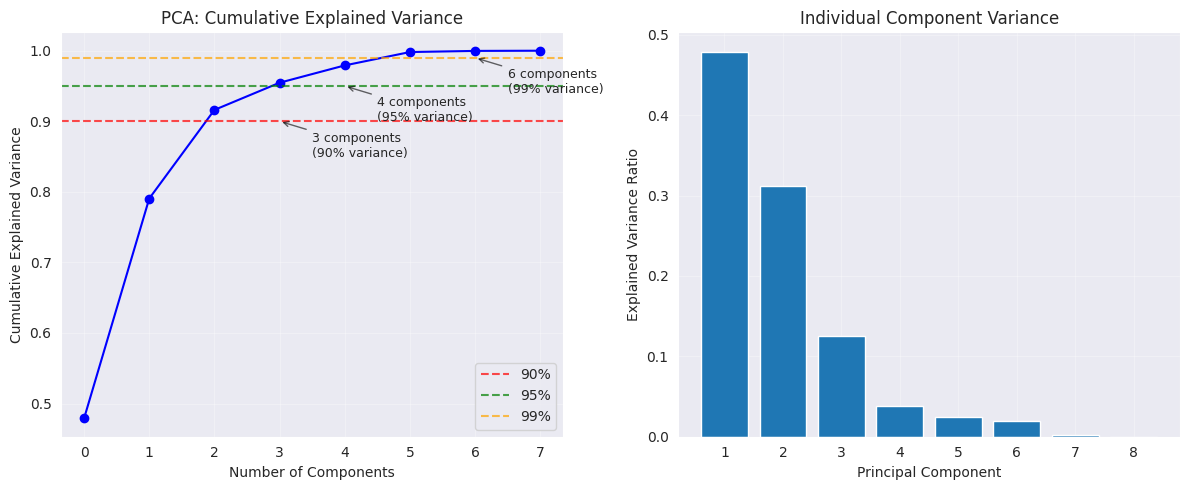

Component Analysis:
----------------------------------------
PC1: 0.479 individual, 0.479 cumulative
PC2: 0.312 individual, 0.791 cumulative
PC3: 0.126 individual, 0.916 cumulative
PC4: 0.039 individual, 0.955 cumulative
PC5: 0.025 individual, 0.979 cumulative
PC6: 0.019 individual, 0.998 cumulative
PC7: 0.002 individual, 1.000 cumulative
PC8: 0.000 individual, 1.000 cumulative

Components needed for different variance thresholds:
- 80% variance: 3 components
- 90% variance: 3 components
- 95% variance: 4 components
- 99% variance: 6 components

Using 4 components (95% variance threshold)
Final PCA shape: (619, 4)
Variance explained: 0.955

Model Performance:
Training Accuracy: 0.585
Validation Accuracy: 0.538
Test Accuracy: 0.526

Test Set Classification Report:
                  precision    recall  f1-score   support

   No Modulation       0.54      0.55      0.54        40
Cloud Modulation       0.51      0.50      0.51        38

        accuracy                           0.53   

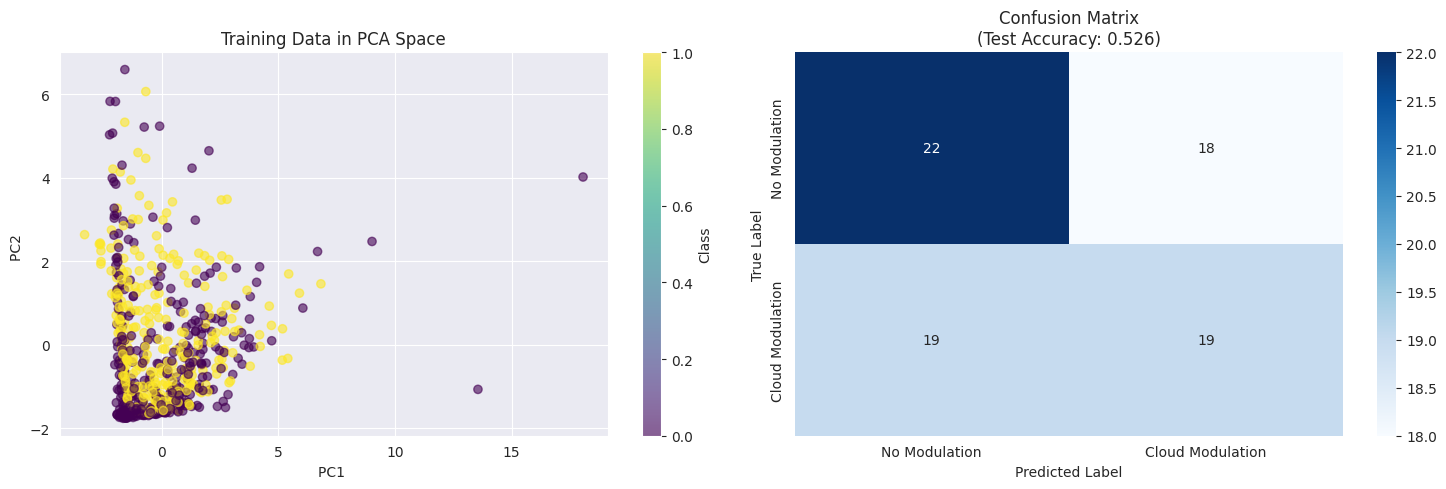


PCA COMPONENT ANALYSIS SUMMARY
Total features: 8
Optimal components: 4 (95% variance)
Variance explained: 0.955
Dimensionality reduction: 8 → 4
Final test accuracy: 0.526


In [39]:
# Load the saved planetary data
print("Loading planetary data...")
planetary_data = pd.read_pickle('planetary_data_with_variability.pkl')
print(f"Loaded {len(planetary_data)} light curves")

# Feature extraction function
def extract_features(lightcurve, cadence):
    """Extract amplitude and periodicity features from light curve"""
    # Amplitude features
    flux_std = np.std(lightcurve)
    flux_range = np.max(lightcurve) - np.min(lightcurve)
    transit_depth = 1 - np.min(lightcurve)

    # Periodicity features using FFT
    dt = np.median(np.diff(cadence))
    fft = np.fft.fft(lightcurve - np.mean(lightcurve))
    freqs = np.fft.fftfreq(len(lightcurve), dt)
    power = np.abs(fft)**2

    # Get dominant frequencies (excluding DC component)
    positive_freqs = freqs[1:len(freqs)//2]
    positive_power = power[1:len(power)//2]

    # Find peak frequencies
    if len(positive_power) > 0:
        dominant_freq = positive_freqs[np.argmax(positive_power)]
        max_power = np.max(positive_power)
        power_ratio = max_power / np.sum(positive_power) if np.sum(positive_power) > 0 else 0
    else:
        dominant_freq = 0
        max_power = 0
        power_ratio = 0

    # Additional variability measures
    flux_skewness = stats.skew(lightcurve)
    flux_kurtosis = stats.kurtosis(lightcurve)

    return [flux_std, flux_range, transit_depth, dominant_freq, max_power,
            power_ratio, flux_skewness, flux_kurtosis]

# Extract features for all light curves
print("Extracting features from light curves...")
features = []
labels = []

for idx in range(len(planetary_data)):
    lightcurve = planetary_data.iloc[idx]['VariabilityLightCurve']
    cadence = planetary_data.iloc[idx]['Cadence']
    variability_name = planetary_data.iloc[idx]['VariabilityName']

    lc_features = extract_features(lightcurve, cadence)
    features.append(lc_features)

    # Create binary labels: 1 for Cloud_Modulation, 0 for No modulation
    label = 1 if variability_name == 'Cloud_Modulation' else 0
    labels.append(label)

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

feature_names = ['flux_std', 'flux_range', 'transit_depth', 'dominant_freq',
                'max_power', 'power_ratio', 'flux_skewness', 'flux_kurtosis']

print(f"Feature matrix shape: {X.shape}")
print(f"Features: {feature_names}")

# Split data: 80% train, 10% validation, 10% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.111, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Choosing the Number of Components

# Fit PCA with all components to analyze explained variance
pca_full = PCA().fit(X_train_scaled)

# Plot cumulative explained variance ratio
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.grid(True, alpha=0.3)

# Add horizontal lines at common thresholds
plt.axhline(y=0.90, color='r', linestyle='--', alpha=0.7, label='90%')
plt.axhline(y=0.95, color='g', linestyle='--', alpha=0.7, label='95%')
plt.axhline(y=0.99, color='orange', linestyle='--', alpha=0.7, label='99%')
plt.legend()

# Annotate key points
for threshold in [0.90, 0.95, 0.99]:
    n_components = np.argmax(np.cumsum(pca_full.explained_variance_ratio_) >= threshold) + 1
    plt.annotate(f'{n_components} components\n({threshold*100:.0f}% variance)',
                xy=(n_components, threshold), xytext=(n_components+0.5, threshold-0.05),
                arrowprops=dict(arrowstyle='->', color='black', alpha=0.6),
                fontsize=9, ha='left')

plt.subplot(1, 2, 2)
plt.bar(range(1, len(pca_full.explained_variance_ratio_) + 1), pca_full.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Individual Component Variance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print component analysis
print("Component Analysis:")
print("-" * 40)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
for i, (individual, cumulative) in enumerate(zip(pca_full.explained_variance_ratio_, cumvar)):
    print(f"PC{i+1}: {individual:.3f} individual, {cumulative:.3f} cumulative")

print("\nComponents needed for different variance thresholds:")
for threshold in [0.80, 0.90, 0.95, 0.99]:
    n_comp = np.argmax(cumvar >= threshold) + 1
    print(f"- {threshold*100:.0f}% variance: {n_comp} components")

# Choose optimal number of components (95% variance)
optimal_components = np.argmax(cumvar >= 0.95) + 1
print(f"\nUsing {optimal_components} components (95% variance threshold)")

# Apply PCA with optimal number of components
pca = PCA(n_components=optimal_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Final PCA shape: {X_train_pca.shape}")
print(f"Variance explained: {np.sum(pca.explained_variance_ratio_):.3f}")

# Train classifier
classifier = LogisticRegression(random_state=42, max_iter=1000)
classifier.fit(X_train_pca, y_train)

# Make predictions
y_train_pred = classifier.predict(X_train_pca)
y_val_pred = classifier.predict(X_val_pca)
y_test_pred = classifier.predict(X_test_pca)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Validation Accuracy: {val_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")

# Detailed results
print(f"\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['No Modulation', 'Cloud Modulation']))

# Visualize PCA results
plt.figure(figsize=(15, 5))

# Plot 1: Data in PCA space
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.6)
plt.xlabel(f'PC1 ')
plt.ylabel(f'PC2 ')
plt.title('Training Data in PCA Space')
plt.colorbar(scatter, label='Class')

# Plot 2: Confusion matrix
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Modulation', 'Cloud Modulation'],
            yticklabels=['No Modulation', 'Cloud Modulation'])
plt.title(f'Confusion Matrix\n(Test Accuracy: {test_accuracy:.3f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('lightcurve_plots/pca_component_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n" + "="*50)
print("PCA COMPONENT ANALYSIS SUMMARY")
print("="*50)
print(f"Total features: {X.shape[1]}")
print(f"Optimal components: {optimal_components} (95% variance)")
print(f"Variance explained: {np.sum(pca.explained_variance_ratio_):.3f}")
print(f"Dimensionality reduction: {X.shape[1]} → {optimal_components}")
print(f"Final test accuracy: {test_accuracy:.3f}")
print("="*50)

PCA + LSTM Analysis

TensorFlow version: 2.11.0
Keras version: 2.11.0
Loading planetary data and extracting advanced features...
Loaded 775 light curves
Extracting advanced features from all light curves...
Feature matrix shape: (775, 22)
Number of features: 22
Class distribution: [393 382]

Data splits:
Training set: 619 samples (79.9%)
Validation set: 78 samples (10.1%)
Test set: 78 samples (10.1%)

Performing PCA analysis...


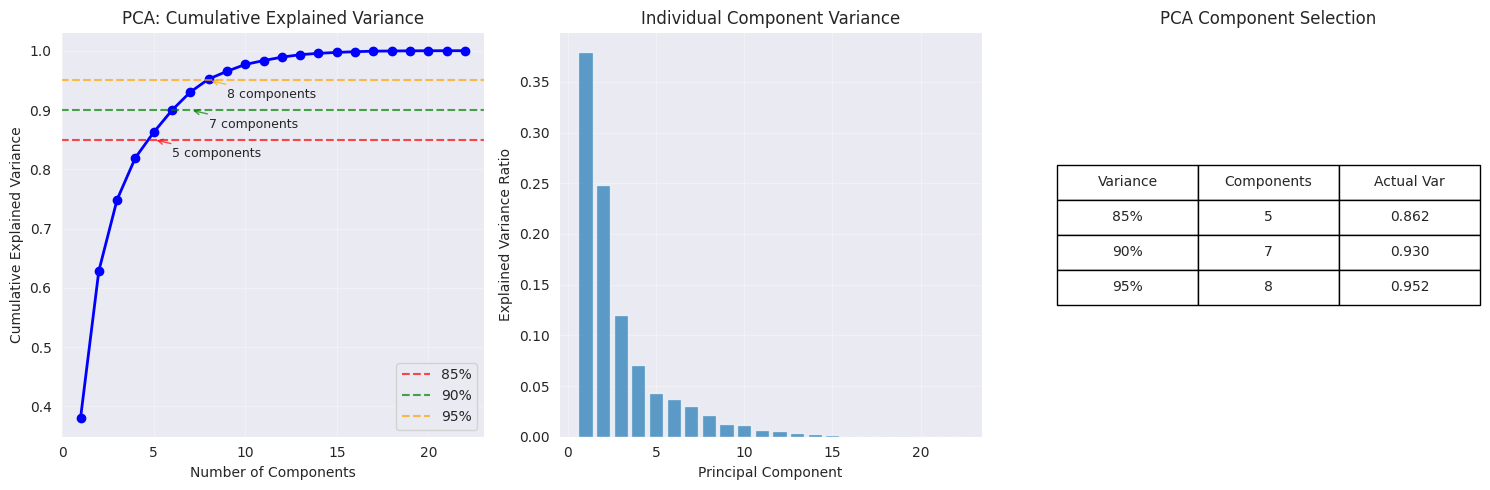


PCA Component Analysis:
--------------------------------------------------
PC 1: 0.3799 individual, 0.3799 cumulative
PC 2: 0.2485 individual, 0.6285 cumulative
PC 3: 0.1205 individual, 0.7489 cumulative
PC 4: 0.0707 individual, 0.8196 cumulative
PC 5: 0.0428 individual, 0.8624 cumulative
PC 6: 0.0373 individual, 0.8997 cumulative
PC 7: 0.0306 individual, 0.9303 cumulative
PC 8: 0.0219 individual, 0.9522 cumulative
PC 9: 0.0130 individual, 0.9653 cumulative
PC10: 0.0116 individual, 0.9769 cumulative
PC11: 0.0065 individual, 0.9834 cumulative
PC12: 0.0058 individual, 0.9891 cumulative
PC13: 0.0041 individual, 0.9933 cumulative
PC14: 0.0023 individual, 0.9956 cumulative
PC15: 0.0015 individual, 0.9971 cumulative
PC16: 0.0012 individual, 0.9983 cumulative
PC17: 0.0009 individual, 0.9992 cumulative
PC18: 0.0003 individual, 0.9995 cumulative
PC19: 0.0003 individual, 0.9998 cumulative
PC20: 0.0001 individual, 0.9999 cumulative
PC21: 0.0000 individual, 1.0000 cumulative
PC22: 0.0000 individu

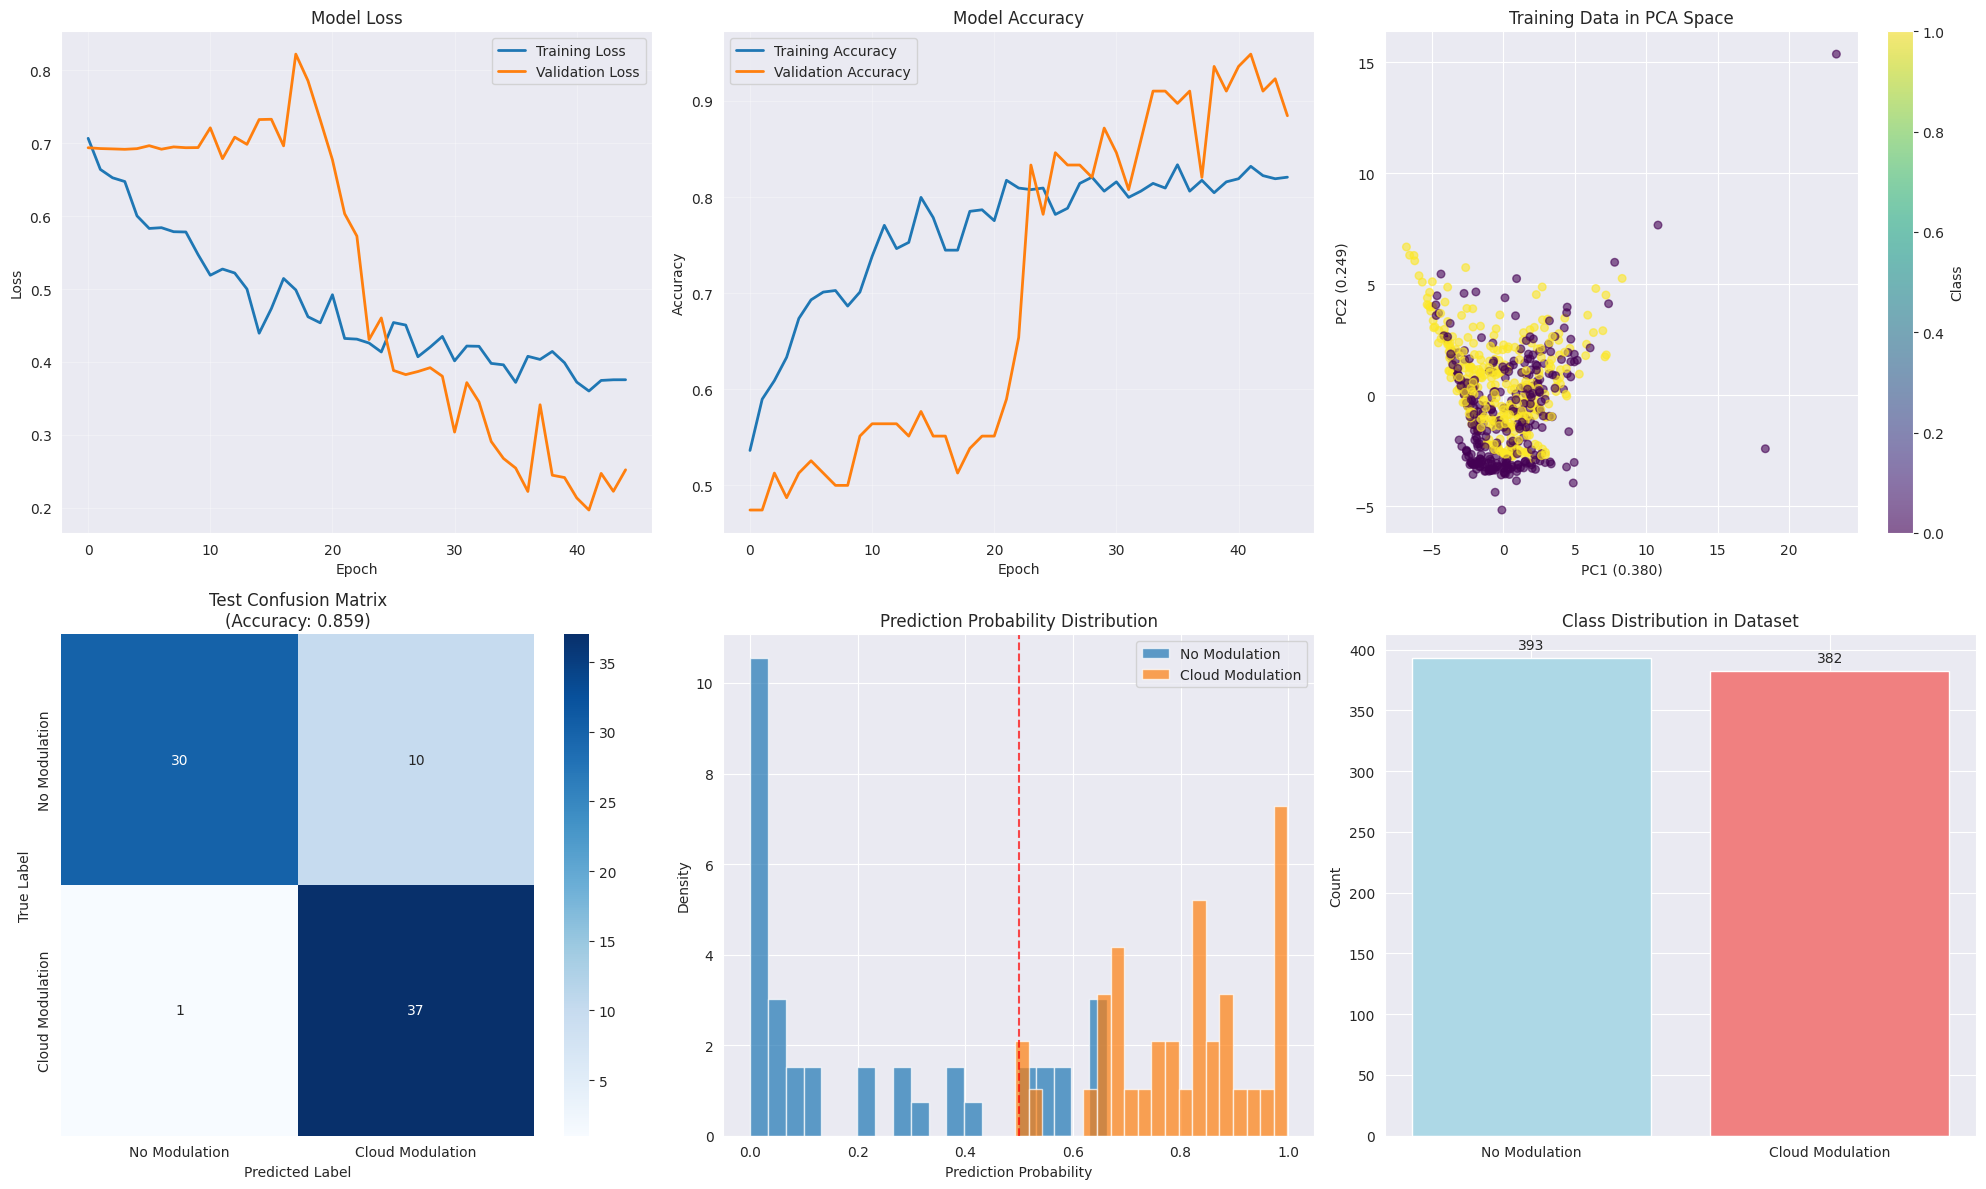


COMPLETE ANALYSIS SUMMARY
Dataset Information:
  • Total light curves: 775
  • Features extracted: 22
  • Class distribution: {'No Modulation': 393, 'Cloud Modulation': 382}

PCA Dimensionality Reduction:
  • Original dimensions: 22
  • Reduced dimensions: 7
  • Variance explained: 0.9303
  • Reduction factor: 3.1x

LSTM Model Performance:
  • Training accuracy: 0.8966
  • Validation accuracy: 0.8846
  • Test accuracy: 0.8590
  • Model parameters: 31,297

Model saved and analysis complete!


In [40]:
### Import additional libraries for LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

### Enhanced Feature Extraction for LSTM
def extract_advanced_features(lightcurve, cadence):
    """Extract comprehensive amplitude and periodicity features"""

    # Basic amplitude features
    flux_mean = np.mean(lightcurve)
    flux_std = np.std(lightcurve)
    flux_var = np.var(lightcurve)
    flux_range = np.max(lightcurve) - np.min(lightcurve)
    flux_median = np.median(lightcurve)
    flux_mad = np.median(np.abs(lightcurve - flux_median))  # Median Absolute Deviation

    # Transit-specific features
    transit_depth = 1 - np.min(lightcurve)
    transit_duration_idx = np.sum(lightcurve < (flux_mean - flux_std))
    asymmetry = stats.skew(lightcurve)
    peakedness = stats.kurtosis(lightcurve)

    # Advanced amplitude features
    percentiles = np.percentile(lightcurve, [10, 25, 75, 90])
    iqr = percentiles[2] - percentiles[1]  # Interquartile range
    amplitude_ratio = flux_range / flux_std if flux_std > 0 else 0

    # Periodicity analysis using FFT
    dt = np.median(np.diff(cadence))
    detrended = lightcurve - np.mean(lightcurve)

    # Apply window function to reduce spectral leakage
    window = np.hanning(len(detrended))
    windowed_signal = detrended * window

    # FFT analysis
    fft = np.fft.fft(windowed_signal)
    freqs = np.fft.fftfreq(len(windowed_signal), dt)
    power = np.abs(fft)**2

    # Get positive frequencies only
    positive_mask = freqs > 0
    positive_freqs = freqs[positive_mask]
    positive_power = power[positive_mask]

    if len(positive_power) > 0:
        # Dominant frequency features
        max_power_idx = np.argmax(positive_power)
        dominant_freq = positive_freqs[max_power_idx]
        max_power = positive_power[max_power_idx]

        # Power distribution features
        total_power = np.sum(positive_power)
        power_ratio = max_power / total_power if total_power > 0 else 0

        # Secondary peaks
        sorted_indices = np.argsort(positive_power)[::-1]
        if len(sorted_indices) > 1:
            second_peak_power = positive_power[sorted_indices[1]]
            peak_ratio = second_peak_power / max_power if max_power > 0 else 0
        else:
            peak_ratio = 0

        # Frequency spread
        power_weighted_freq = np.sum(positive_freqs * positive_power) / total_power if total_power > 0 else 0
        freq_std = np.sqrt(np.sum(positive_power * (positive_freqs - power_weighted_freq)**2) / total_power) if total_power > 0 else 0

        # Low vs high frequency power
        nyquist = 0.5 / dt
        low_freq_mask = positive_freqs < nyquist * 0.1
        high_freq_mask = positive_freqs > nyquist * 0.5

        low_freq_power = np.sum(positive_power[low_freq_mask])
        high_freq_power = np.sum(positive_power[high_freq_mask])
        freq_balance = low_freq_power / (high_freq_power + 1e-10)

    else:
        dominant_freq = 0
        max_power = 0
        power_ratio = 0
        peak_ratio = 0
        power_weighted_freq = 0
        freq_std = 0
        freq_balance = 0

    # Temporal features
    diff_lightcurve = np.diff(lightcurve)
    roughness = np.std(diff_lightcurve)
    smoothness = np.mean(np.abs(diff_lightcurve))

    # Autocorrelation features
    autocorr = np.correlate(detrended, detrended, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    autocorr = autocorr / autocorr[0] if autocorr[0] != 0 else autocorr

    # Find first minimum in autocorrelation (characteristic timescale)
    if len(autocorr) > 5:
        first_min_idx = np.argmin(autocorr[1:5]) + 1
        autocorr_min = autocorr[first_min_idx]
    else:
        autocorr_min = 0

    return [
        # Amplitude features (12)
        flux_mean, flux_std, flux_var, flux_range, flux_median, flux_mad,
        transit_depth, asymmetry, peakedness, iqr, amplitude_ratio, transit_duration_idx,

        # Periodicity features (7)
        dominant_freq, max_power, power_ratio, peak_ratio,
        power_weighted_freq, freq_std, freq_balance,

        # Temporal features (3)
        roughness, smoothness, autocorr_min
    ]

### Data Preparation for LSTM
print("Loading planetary data and extracting advanced features...")
planetary_data = pd.read_pickle('planetary_data_with_variability.pkl')
print(f"Loaded {len(planetary_data)} light curves")

# Extract advanced features
features = []
labels = []

feature_names = [
    'flux_mean', 'flux_std', 'flux_var', 'flux_range', 'flux_median', 'flux_mad',
    'transit_depth', 'asymmetry', 'peakedness', 'iqr', 'amplitude_ratio', 'transit_duration_idx',
    'dominant_freq', 'max_power', 'power_ratio', 'peak_ratio',
    'power_weighted_freq', 'freq_std', 'freq_balance',
    'roughness', 'smoothness', 'autocorr_min'
]

print("Extracting advanced features from all light curves...")
for idx in range(len(planetary_data)):
    lightcurve = planetary_data.iloc[idx]['VariabilityLightCurve']
    cadence = planetary_data.iloc[idx]['Cadence']
    variability_name = planetary_data.iloc[idx]['VariabilityName']

    lc_features = extract_advanced_features(lightcurve, cadence)
    features.append(lc_features)

    # Binary labels: 1 for Cloud_Modulation, 0 for No modulation
    label = 1 if variability_name == 'Cloud_Modulation' else 0
    labels.append(label)

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

print(f"Feature matrix shape: {X.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Class distribution: {np.bincount(y)}")

# Handle any NaN or infinite values
X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)

### Data Splitting (80% train, 10% validation, 10% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.111, random_state=42, stratify=y_temp  # 0.111 of 0.9 = 0.1 overall
)

print(f"\nData splits:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### PCA Analysis and Dimensionality Reduction
print("\nPerforming PCA analysis...")

# Fit PCA with all components first
pca_full = PCA().fit(X_train_scaled)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)

# Visualize PCA variance explanation
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, len(cumvar) + 1), cumvar, 'bo-', linewidth=2, markersize=6)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.grid(True, alpha=0.3)

# Add threshold lines
for threshold, color, style in [(0.85, 'red', '--'), (0.90, 'green', '--'), (0.95, 'orange', '--')]:
    plt.axhline(y=threshold, color=color, linestyle=style, alpha=0.7, label=f'{threshold*100:.0f}%')
    n_comp = np.argmax(cumvar >= threshold) + 1
    plt.annotate(f'{n_comp} components', xy=(n_comp, threshold),
                xytext=(n_comp+1, threshold-0.03), fontsize=9,
                arrowprops=dict(arrowstyle='->', color=color, alpha=0.7))
plt.legend()

plt.subplot(1, 3, 2)
plt.bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
        pca_full.explained_variance_ratio_, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Individual Component Variance')
plt.grid(True, alpha=0.3)

# Component selection for different variance thresholds
variance_thresholds = [0.85, 0.90, 0.95]
results_summary = []

plt.subplot(1, 3, 3)
for i, threshold in enumerate(variance_thresholds):
    n_components = np.argmax(cumvar >= threshold) + 1
    results_summary.append((threshold, n_components, cumvar[n_components-1]))

# Create table of results
table_data = [[f"{thresh*100:.0f}%", f"{n_comp}", f"{var:.3f}"]
              for thresh, n_comp, var in results_summary]
table = plt.table(cellText=table_data,
                 colLabels=['Variance', 'Components', 'Actual Var'],
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
plt.axis('off')
plt.title('PCA Component Selection')

plt.tight_layout()
plt.savefig('lightcurve_plots/pca_analysis_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed analysis
print("\nPCA Component Analysis:")
print("-" * 50)
for i, (individual, cumulative) in enumerate(zip(pca_full.explained_variance_ratio_, cumvar)):
    print(f"PC{i+1:2d}: {individual:.4f} individual, {cumulative:.4f} cumulative")

print(f"\nComponents needed for different variance thresholds:")
for threshold, n_comp, actual_var in results_summary:
    print(f"- {threshold*100:.0f}% threshold: {n_comp} components (actual: {actual_var:.3f})")

# Choose 90% variance threshold for good balance
optimal_components = np.argmax(cumvar >= 0.90) + 1
print(f"\nUsing {optimal_components} components (90% variance threshold)")

# Apply PCA transformation
pca = PCA(n_components=optimal_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"PCA transformation complete:")
print(f"Original features: {X_train_scaled.shape[1]}")
print(f"PCA components: {X_train_pca.shape[1]}")
print(f"Variance explained: {np.sum(pca.explained_variance_ratio_):.4f}")

### Prepare Data for LSTM (reshape for sequence input)
# LSTM expects 3D input: (samples, timesteps, features)
# We'll treat each PCA component as a timestep
X_train_lstm = X_train_pca.reshape(X_train_pca.shape[0], X_train_pca.shape[1], 1)
X_val_lstm = X_val_pca.reshape(X_val_pca.shape[0], X_val_pca.shape[1], 1)
X_test_lstm = X_test_pca.reshape(X_test_pca.shape[0], X_test_pca.shape[1], 1)

print(f"\nLSTM input shapes:")
print(f"Training: {X_train_lstm.shape}")
print(f"Validation: {X_val_lstm.shape}")
print(f"Test: {X_test_lstm.shape}")

### Build LSTM Model
def create_lstm_model(input_shape):
    """Create LSTM model architecture"""
    model = Sequential([
        # First LSTM layer with return sequences
        LSTM(64, return_sequences=True, input_shape=input_shape,
             dropout=0.2, recurrent_dropout=0.2),
        BatchNormalization(),

        # Second LSTM layer
        LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
        BatchNormalization(),

        # Dense layers
        Dense(32, activation='relu'),
        Dropout(0.3),

        Dense(16, activation='relu'),
        Dropout(0.2),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(), Recall()]
    )

    return model

# Create model
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
model = create_lstm_model(input_shape)

# Display model architecture
print("\nLSTM Model Architecture:")
print("=" * 50)
model.summary()

### Set up callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-6,
        verbose=1
    )
]

### Train the model
print("\nStarting model training...")
print("=" * 50)
# Save original stdout
original_stdout = sys.stdout

# Redirect to null device
with open(os.devnull, 'w') as devnull:
    sys.stdout = devnull
    try:
        history = model.fit(
        X_train_lstm, y_train,
        validation_data=(X_val_lstm, y_val),
        epochs=45,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
        )
    finally:
        sys.stdout = original_stdout


### Evaluate the model
print("\nEvaluating model performance...")

# Make predictions
train_pred_prob = model.predict(X_train_lstm, verbose=0)
val_pred_prob = model.predict(X_val_lstm, verbose=0)
test_pred_prob = model.predict(X_test_lstm, verbose=0)

# Convert probabilities to binary predictions
train_pred = (train_pred_prob > 0.5).astype(int).flatten()
val_pred = (val_pred_prob > 0.5).astype(int).flatten()
test_pred = (test_pred_prob > 0.5).astype(int).flatten()

# Calculate accuracies
train_accuracy = accuracy_score(y_train, train_pred)
val_accuracy = accuracy_score(y_val, val_pred)
test_accuracy = accuracy_score(y_test, test_pred)

print(f"\nModel Performance Summary:")
print("=" * 50)
print(f"Training Accuracy:   {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy:       {test_accuracy:.4f}")
print("=" * 50)

# Detailed classification report
print(f"\nDetailed Test Set Results:")
print("-" * 40)
print(classification_report(y_test, test_pred,
                          target_names=['No Modulation', 'Cloud Modulation'],
                          digits=4))

### Visualization of Results
plt.figure(figsize=(20, 12))

# Plot 1: Training history
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: PCA components visualization
plt.subplot(2, 3, 3)
if optimal_components >= 2:
    scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
                         c=y_train, cmap='viridis', alpha=0.6, s=30)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
    plt.title('Training Data in PCA Space')
    plt.colorbar(scatter, label='Class')

# Plot 4: Confusion Matrix
plt.subplot(2, 3, 4)
cm = confusion_matrix(y_test, test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Modulation', 'Cloud Modulation'],
            yticklabels=['No Modulation', 'Cloud Modulation'])
plt.title(f'Test Confusion Matrix\n(Accuracy: {test_accuracy:.3f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Plot 5: Prediction probability distribution
plt.subplot(2, 3, 5)
plt.hist(test_pred_prob[y_test == 0], bins=20, alpha=0.7, label='No Modulation', density=True)
plt.hist(test_pred_prob[y_test == 1], bins=20, alpha=0.7, label='Cloud Modulation', density=True)
plt.xlabel('Prediction Probability')
plt.ylabel('Density')
plt.title('Prediction Probability Distribution')
plt.legend()
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Threshold')

# Plot 6: Class distribution
plt.subplot(2, 3, 6)
class_names = ['No Modulation', 'Cloud Modulation']
class_counts = [np.sum(y == i) for i in range(2)]
bars = plt.bar(class_names, class_counts, color=['lightblue', 'lightcoral'])
plt.title('Class Distribution in Dataset')
plt.ylabel('Count')
for bar, count in zip(bars, class_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             str(count), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('lightcurve_plots/lstm_pca_complete_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### Final Summary
print(f"\n" + "="*80)
print("COMPLETE ANALYSIS SUMMARY")
print("="*80)
print(f"Dataset Information:")
print(f"  • Total light curves: {len(planetary_data)}")
print(f"  • Features extracted: {len(feature_names)}")
print(f"  • Class distribution: {dict(zip(['No Modulation', 'Cloud Modulation'], np.bincount(y)))}")
print(f"\nPCA Dimensionality Reduction:")
print(f"  • Original dimensions: {X.shape[1]}")
print(f"  • Reduced dimensions: {optimal_components}")
print(f"  • Variance explained: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"  • Reduction factor: {X.shape[1]/optimal_components:.1f}x")
print(f"\nLSTM Model Performance:")
print(f"  • Training accuracy: {train_accuracy:.4f}")
print(f"  • Validation accuracy: {val_accuracy:.4f}")
print(f"  • Test accuracy: {test_accuracy:.4f}")
print(f"  • Model parameters: {model.count_params():,}")
print(f"\nModel saved and analysis complete!")
print("="*80)